In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

from PIL import Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

import time
from tensorboard import Tensorboard
from constant import *

# Test if this imporve runtime (People claim that this improve runtime if input size is the same)
# import torch.backend.cudnn as cudnn
# cudnn.benchmark=True

/home/dattran/miniconda2/envs/dat/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
optim.?

Init signature: optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
Docstring:     
Implements RMSprop algorithm.

Proposed by G. Hinton in his
`course <http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf>`_.

The centered version first appears in `Generating Sequences
With Recurrent Neural Networks <https://arxiv.org/pdf/1308.0850v5.pdf>`_.

Arguments:
    params (iterable): iterable of parameters to optimize or dicts defining
        parameter groups
    lr (float, optional): learning rate (default: 1e-2)
    momentum (float, optional): momentum factor (default: 0)
    alpha (float, optional): smoothing constant (default: 0.99)
    eps (float, optional): term added to the denominator to improve
        numerical stability (default: 1e-8)
    centered (bool, optional) : if ``True``, compute the centered RMSProp,
        the gradient is normalized by an estimation of its variance
    weight_decay (float, optional): weigh

### Utitlity for traininng and testing

In [6]:
class XrayDataset(Dataset):
    '''
    Get image for train, validate and test base on NIH split
    '''
    
    def __init__(self, 
                 image_list_file='test_list.csv', 
                 transform=None, 
                 percentage=0.01):
        data = pd.read_csv(image_list_file, sep=' ', header=None)
        self.images = data.iloc[:, 0].as_matrix()
        self.labels = data.iloc[:, 1:].as_matrix()
        self.transform = transform
        self.percentage = percentage
    
    def __getitem__(self, index):
        image_file = DATA_DIR + self.images[index]
        image = Image.open(image_file).convert('RGB')
#         image = imread(image_file)
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, torch.FloatTensor(label)
    
    def __len__(self):
        return int(self.images.shape[0] * self.percentage)

In [7]:
class DenseNet121(nn.Module):
    
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.densenet121(x)
        return x
    
    def extract(self, x):
        extractor = nn.Sequential(
                *list(self.densenet121.features.children())[:-1]
            )
        return extractor.forward(x)


In [8]:
def train_dataloader(image_list_file='train_val_list.csv', percentage=PERCENTAGE):
    # TODO: Implement kFold for train test split
    normalize = transforms.Normalize(IMAGENET_RGB_MEAN, IMAGENET_RGB_SD)
    transform = transforms.Compose([
        transforms.Resize(264),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=WIDTH),
        transforms.ColorJitter(0.15, 0.15),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        normalize
    ])
    dataset = XrayDataset(image_list_file, transform, percentage)
    return DataLoader(dataset=dataset, batch_size=BATCHSIZE,
                      shuffle=True, num_workers=2, pin_memory=False)

In [9]:
def test_dataloader(image_list_file='test_list.csv', percentage=PERCENTAGE, agumented=TEST_AGUMENTED):
    normalize = transforms.Normalize(IMAGENET_RGB_MEAN, IMAGENET_RGB_SD)
    if agumented:
        # base on https://github.com/arnoweng/CheXNet/blob/master/model.py
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.TenCrop(WIDTH),
            transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
            transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops]))
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize(WIDTH),
            transforms.ToTensor(),
            normalize
        ])
    dataset = XrayDataset(image_list_file, transform, percentage)
    return DataLoader(dataset=dataset, batch_size=4*BATCHSIZE,
                      shuffle=False, num_workers=4, pin_memory=False)

In [20]:
def train(model, dataloader, optimizer, criterion, epoch, batches, logger):
    model.train()
    iterator = iter(dataloader)
    stime = time.time()
    for i in range(batches):
        data, target = iterator.next()
        data = Variable(torch.FloatTensor(data).cuda())
        target = Variable(torch.FloatTensor(target).cuda())
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        print('Loss', loss.data[0])
        loss.backward()
        optimizer.step()
        duration = time.time() - stime
#         print('Epochs: [%d][%d/%d]\tTime: %.3f \tLoss: %2.3f' % (epoch, i+1, batches, duration, loss))
        stime += duration
        logger.scalar_summary('train_loss', loss.data, epoch * batches + i + 1)

In [11]:
def validate(model, dataloader, criterion):
    model.eval()
    losses = []
    targets = torch.FloatTensor().cuda()
    preds = torch.FloatTensor().cuda()
    
    for data, target in dataloader:
        data = Variable(torch.FloatTensor(data).cuda(), volatile=True)
        target = Variable(torch.FloatTensor(target).cuda(), volatile=True)
        pred = model(data)
        loss = criterion(pred, target)
        losses.append(loss.data[0])
        targets = torch.cat((targets, target.data), 0)
        preds = torch.cat((preds, pred.data), 0)
    aurocs = compute_aucs(targets, preds)
    aurocs_mean = np.array(aurocs).mean()
    print('The average AUROC is %.3f' % aurocs_mean)
    return np.mean(losses), aurocs_mean
        

In [12]:
def test(model, dataloader, agumented=TEST_AGUMENTED):
    model.eval()
    targets = torch.FloatTensor()
    targets = targets.cuda()
    preds = torch.FloatTensor()
    preds = preds.cuda()
    
    for data, target in dataloader:
        target = target.cuda()
        if agumented:
            bs, cs, c, h, w = data.size()
            data = data.view(-1, c, h, w)
        data = Variable(data.cuda(), volatile=True)
        pred = model(data)
        if agumented:
            pred = pred.view(bs, cs, -1).mean(1)
        targets = torch.cat((targets, target), 0)
        preds = torch.cat((preds, pred.data), 0)
    aurocs = compute_aucs(targets, preds)
    aurocs_avg = np.array(aurocs).mean()
    
    print('The average AUROC is {0:.3f}'.format(aurocs_avg))
    for i in range(N_CLASSES):
        print('The AUROC of {} is {}'.format(CLASS_NAMES[i], aurocs[i]))

In [13]:
def compute_aucs(targets, preds):
    aurocs = []
    targets = targets.cpu().numpy()
    preds = preds.cpu().numpy()
    for i in range(N_CLASSES):
        aurocs.append(roc_auc_score(targets[:, i], preds[:, i]))
    return aurocs

In [14]:
%%time
net = DenseNet121(N_CLASSES).cuda()
parallel_net = torch.nn.DataParallel(net, device_ids=[0]).cuda()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min')

CPU times: user 3.03 s, sys: 1.3 s, total: 4.33 s
Wall time: 8.06 s


In [16]:
# scheduler

In [ ]:
p = optimizer.state_dict()['param_groups'][0]
p.pop('params')
p

### Training

In [21]:
train_loader = train_dataloader(image_list_file=CHEXNET_TRAIN_CSV, percentage=1)
valid_loader = test_dataloader(image_list_file=CHEXNET_VAL_CSV, percentage=0.1, agumented=False)

stime = time.time()
# batches = min(BATCHES, len(train_loader))
batches = 10
epochs = 2
loss_min = float('inf')
logger = Tensorboard('%s/temp/')
for e in range(epochs):
    # train
    train(parallel_net, train_loader, optimizer, criterion, e, batches, logger)
    loss_val, aurocs_mean = validate(parallel_net, valid_loader, criterion)
    scheduler.step(loss_val)
    
    # Tensorboard hook
    
    # save best model
    if loss_val < loss_min:
        loss_min = loss_val
        torch.save({
            'epoch': e+1,
            'state_dict': parallel_net.state_dict(),
            'best_loss': loss_min,
            'aurocs_mean': aurocs_mean,
            'optimizer': optimizer.state_dict()
        }, 'densenet.path.tar')
    

Loss 0.19080713391304016
Loss 0.27967697381973267


Process Process-6:
Traceback (most recent call last):
Process Process-5:
  File "/home/dattran/miniconda2/envs/dat/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/dattran/miniconda2/envs/dat/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/dattran/miniconda2/envs/dat/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/dattran/miniconda2/envs/dat/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 55, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/dattran/miniconda2/envs/dat/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "<ipython-input-6-d78332875a51>", line 18, in __getitem__
    image = Image.open(image_file).convert('RGB')
  Fi

KeyboardInterrupt: 

In [56]:
# optimizer.state_dict()['param_groups']
p = optimizer.state_dict()['param_groups'][0]
p.pop('params')
p

{'betas': (0.9, 0.999), 'eps': 1e-08, 'lr': 0.001, 'weight_decay': 0}

### Testing
Should testing on strong label images

In [20]:
checkpoint = torch.load(MODEL_NAME)
parallel_net.load_state_dict(checkpoint['state_dict'])

#### Test on non-agumented data

In [21]:
%%time
test_loader = test_dataloader(image_list_file='chexnet_test_list.txt', percentage=1, agumented=False)
test(parallel_net, test_loader, agumented=False)

The average AUROC is 0.836
The AUROC of Atelectasis is 0.824873191929378
The AUROC of Cardiomegaly is 0.9060691584884254
The AUROC of Effusion is 0.883285510585788
The AUROC of Infiltration is 0.7115769213289909
The AUROC of Mass is 0.8503588876595851
The AUROC of Nodule is 0.7811796066368363
The AUROC of Pneumonia is 0.7686261387331846
The AUROC of Pneumothorax is 0.8685184568528409
The AUROC of Consolidation is 0.8058306392613814
The AUROC of Edema is 0.8900069384424901
The AUROC of Emphysema is 0.9206112632709746
The AUROC of Fibrosis is 0.8224053287594457
The AUROC of Pleural_Thickening is 0.7767299074418351
The AUROC of Hernia is 0.8982244141459897
CPU times: user 17.5 s, sys: 3.4 s, total: 20.9 s
Wall time: 2min 33s


#### Test on agumented data

In [24]:
%%time
test_agumented_loader = test_dataloader(image_list_file='chexnet_test_list.txt', percentage=1, agumented=True)
test(parallel_net, test_agumented_loader, agumented=True)

The average AUROC is 0.843
The AUROC of Atelectasis is 0.8294420919790566
The AUROC of Cardiomegaly is 0.9165184038539053
The AUROC of Effusion is 0.8870481061265705
The AUROC of Infiltration is 0.7143161899411135
The AUROC of Mass is 0.8597177711754492
The AUROC of Nodule is 0.787343706895909
The AUROC of Pneumonia is 0.7745063425683334
The AUROC of Pneumothorax is 0.8726774482937596
The AUROC of Consolidation is 0.8142353944516423
The AUROC of Edema is 0.8932537666616086
The AUROC of Emphysema is 0.9253600310269912
The AUROC of Fibrosis is 0.8303904200682328
The AUROC of Pleural_Thickening is 0.7831004467489492
The AUROC of Hernia is 0.9104476500975094
CPU times: user 4min 23s, sys: 1min 58s, total: 6min 22s
Wall time: 6min 26s


### CAM

In [44]:
# class FeatureExtractor(DenseNet121):
    
#     def __init__(self):
#         super(FeatureExtractor, self).__init__(14) 
    
#     def extract(self):
#         self.extractor = nn.Sequential(
#             *list(self.densenet121.features.children())[:-1]
#         )
#         print('extractor')
        
#     def forward(self, x):
#         return self.extractor.forward(x)



# extractor = FeatureExtractor().cuda()
# extractor_paralle = torch.nn.DataParallel(extractor, device_ids=[0]).cuda()
# extractor_paralle.load_state_dict(checkpoint['state_dict'])
# extractor.extract()


extractor


In [107]:
def cam_data(image_file_list, n=10):
    '''
    Get n random image from image_file_list for CAM visualization
    '''
    normallize = transforms.Normalize(IMAGENET_RGB_MEAN, IMAGENET_RGB_SD)
    transform = transforms.Compose([
        transforms.Resize(WIDTH),
        transforms.ToTensor(),
        normallize
    ])
    dataset = XrayDataset(image_file_list, 
                          percentage=1)
    idx = np.random.randint(0, len(dataset))
    images = []
    labels = []
    inputs = []
    for i in idx:
        image, label = dataset[i]
        input = transform(image)
        
    

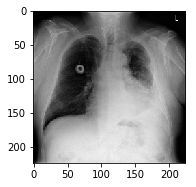

In [35]:
def get_score_and_cam_picture(image, densenet, feature_extractor):
    print(image.size)

parallel_net.eval()
dataset = XrayDataset()
image, label = dataset[4]
normallize = transforms.Normalize(IMAGENET_RGB_MEAN, IMAGENET_RGB_SD)
transform = transforms.Compose([
        transforms.Resize(WIDTH),
        transforms.ToTensor(),
        normallize
    ])

data = transform(image).unsqueeze(0)
# data = transform(image)
data = Variable(data.cuda())

plt.subplot(121)
image = np.asarray(image)
image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
plt.imshow(image)

prediction = parallel_net(data)
conv_output = net.extract(data)
class_weights = list(parallel_net.modules())[-2].weight
prediction = prediction.cpu().data.numpy().squeeze()
conv_output = conv_output.cpu().data.numpy().squeeze()
class_weights = class_weights.cpu().data.numpy().squeeze()
predicted_disease = np.argmax(prediction)
cam = np.zeros(dtype=np.float32, shape=conv_output.shape[1:])
for i, w in enumerate(class_weights[predicted_disease, :]):
    cam += w * conv_output[predicted_disease, :, :]

In [30]:
def plot_cam_results(crt_blended_image, crt_cam_image, crt_xray_image, map_caption):
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize = (15,7))

    ax1 = fig.add_subplot(2, 3, 1)
    ax1.imshow(crt_xray_image, cmap = 'gray', interpolation = 'bicubic')
    ax1.set_title('Orig X Ray')
    plt.axis('off')

    ax2 = fig.add_subplot(2,3, 2)
    cam_plot = ax2.imshow(crt_cam_image, cmap=plt.get_cmap('OrRd'), interpolation = 'bicubic')
    plt.colorbar(cam_plot, ax=ax2)
    ax2.set_title('Activation Map')
    plt.axis('off')

    ax3 = fig.add_subplot(2,3, 3)
    blended_plot = ax3.imshow(crt_blended_image, interpolation = 'bicubic')
    plt.colorbar(cam_plot, ax=ax3)
    ax3.set_title(map_caption)
    plt.axis('off')
    plt.show()

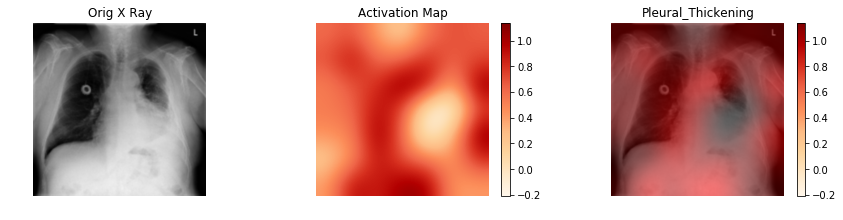

In [36]:
from azure_chestxray_cam import process_cam_image
blended_image = process_cam_image(cam, image)
plot_cam_results(blended_image, cam, image, CLASS_NAMES[predicted_disease])

In [45]:
# print(list(net.modules())[-5])
# print(list(net.modules())[-2].weight)
# relu = list(net.modules())[-2]
# print(relu)
# print(relu._tracing_name())
# dir(relu)

Parameter containing:
 1.1485e-15 -1.5641e-30 -3.4543e-26  ...   8.0709e-03  5.2040e-03 -1.1303e-02
-3.8946e-23  4.1429e-41 -5.7048e-41  ...  -2.4264e-02  5.1766e-02 -4.4727e-02
-2.8098e-16 -4.6195e-18  4.1032e-22  ...  -8.2214e-03  3.4137e-03  2.8350e-02
                ...                   ⋱                   ...                
-1.4152e-31  4.5839e-41 -6.3681e-41  ...  -1.4952e-02 -2.7632e-04  6.0646e-02
-2.8207e-19  4.8006e-41 -9.0286e-40  ...   9.3225e-03 -3.3108e-03  1.9259e-02
-7.4941e-39  1.4761e-41 -3.8886e-42  ...  -9.2289e-03 -5.1923e-02  2.4457e-02
[torch.cuda.FloatTensor of size 14x1024 (GPU 0)]



In [41]:
# for data, target in test_loader:
#     print(type(data), data.size())
#     print(type(target), data.size())
#     break

<class 'torch.FloatTensor'> torch.Size([64, 3, 224, 224])
<class 'torch.FloatTensor'> torch.Size([64, 3, 224, 224])


In [66]:
# print(densenet)